# 잔차분석

## #01. 잔차분석의 이해

### [1] 잔차

실제 관측값과 예측값의 사이

즉, 예측값에 대한 오차를 의미함

$$잔차=실제관측값−예측값$$

### [2] 잔차 분석

회귀분석 수행 후 회귀 분석이 적절하게 수행되었는지, 모델이 데이터에 적합한지를 평가하기 위해 사용

아래의 요건들을 충족할 경우 회귀분석의 결과를 신뢰할 수 있다고 판단함.

| 구분 | 검정 방법 |
|---|---|
| 선형성 | 잔차에 대한 정규분포 확인 / 잔차 그래프 시각화 |
| 정규성 | 잔차에 대한 normaltest, shapiro, Kolmogorov-Smirnov 검정 / QQPlot, 잔차도 시각화 |
| 등분산성 | Breusch-Pagan, Brown-Forsythe 검정 |
| 독립성 | 더빈 왓슨 통계량 |

## #02. 준비작업

### [1] 패키지 참조

In [1]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from my_helper.regression import *
from my_helper.util import *
from my_helper.plot import *
from my_helper.analysis import *

from pandas import DataFrame
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import zscore, probplot

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)
my_pretty_table(origin.head())

+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 6.0622 | 

## #02. 선형회귀 분석

앞 예제에서 도출한 과정을 재현한다.

### [1] 데이터 전처리

#### (1) 불필요한 요인 제거

In [3]:
ignore = ['TAX', 'INDUS', 'AGE', 'CHAS', 'CRIM', 'RAD', 'ZN', 'B']
df = origin.drop(ignore, axis=1)
my_pretty_table(df.head())

+----+-------+-------+--------+-----------+---------+--------+
|    |   NOX |    RM |    DIS |   PTRATIO |   LSTAT |   MEDV |
|----+-------+-------+--------+-----------+---------+--------|
|  0 | 0.538 | 6.575 |   4.09 |      15.3 |    4.98 |     24 |
|  1 | 0.469 | 6.421 | 4.9671 |      17.8 |    9.14 |   21.6 |
|  2 | 0.469 | 7.185 | 4.9671 |      17.8 |    4.03 |   34.7 |
|  3 | 0.458 | 6.998 | 6.0622 |      18.7 |    2.94 |   33.4 |
|  4 | 0.458 | 7.147 | 6.0622 |      18.7 |    5.33 |   36.2 |
+----+-------+-------+--------+-----------+---------+--------+


### [2] 데이터 분할

In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df, yname="MEDV", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((354, 5), (152, 5), (354,), (152,))

### [3] 선형회귀 분석

MEDV = -1.661 * NOX + 3.516 * RM + -2.192 * DIS + -2.192 * PTRATIO + -3.987 * LSTAT + 22.762
+------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|            |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 훈련데이터 |       0.745825 |             3.27197 |             21.8049 |          4.66958 |                         16.9054 |              -3.61383 |
| 검증데이터 |       0.603232 |             3.97022 |               32.07 |          5.66304 |                         21.3872 |              -5.53031 |
+------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
[훈련데이터에 대한 결과보고]
+----+------------

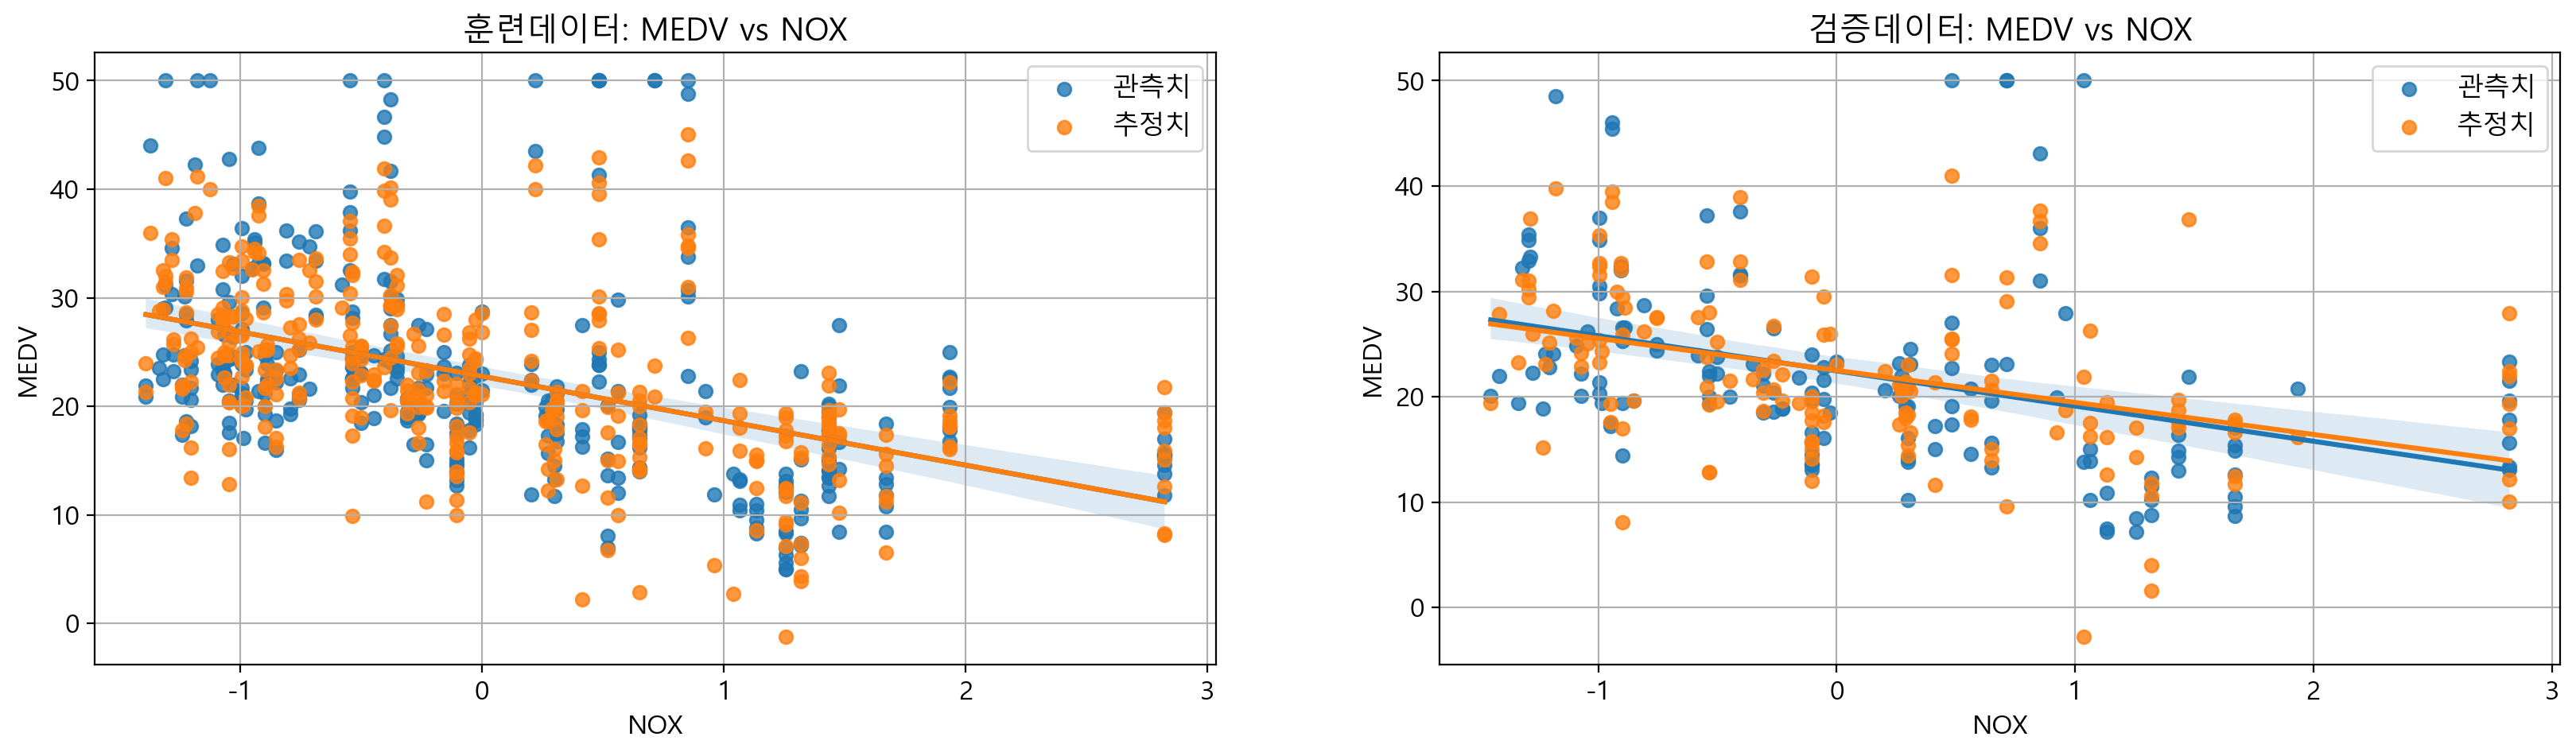

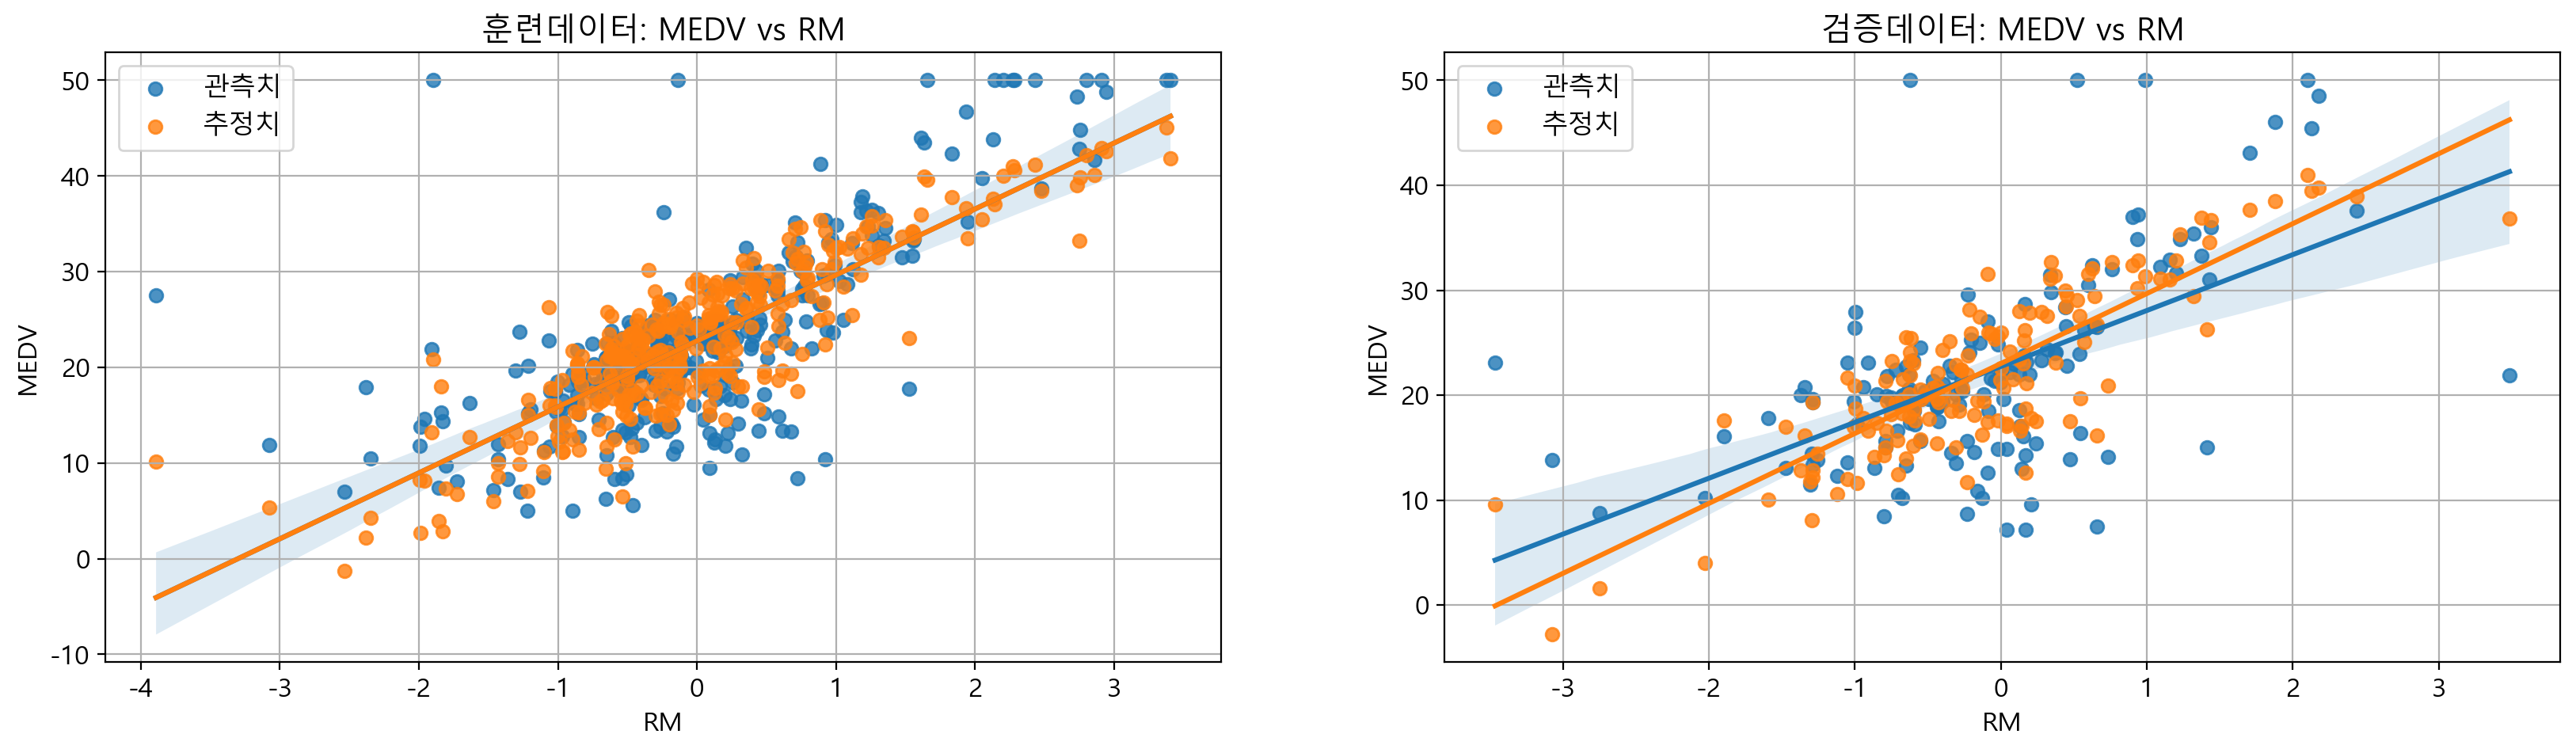

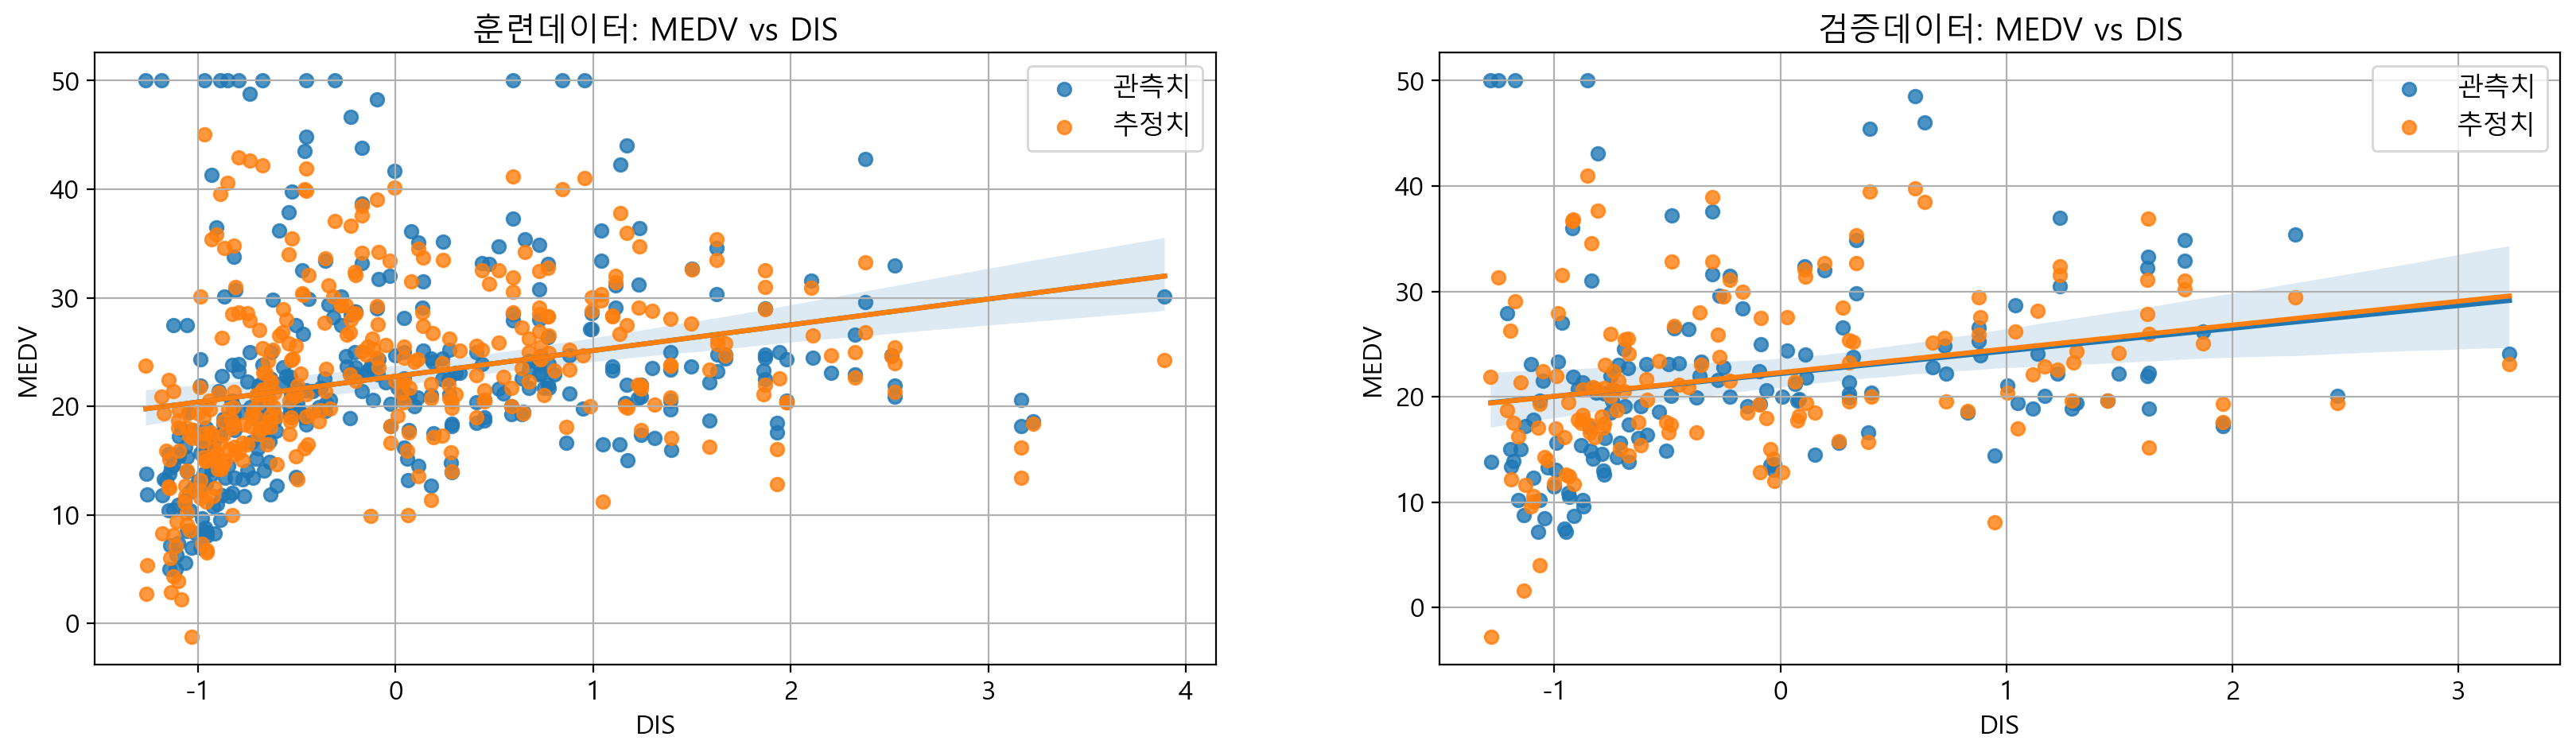

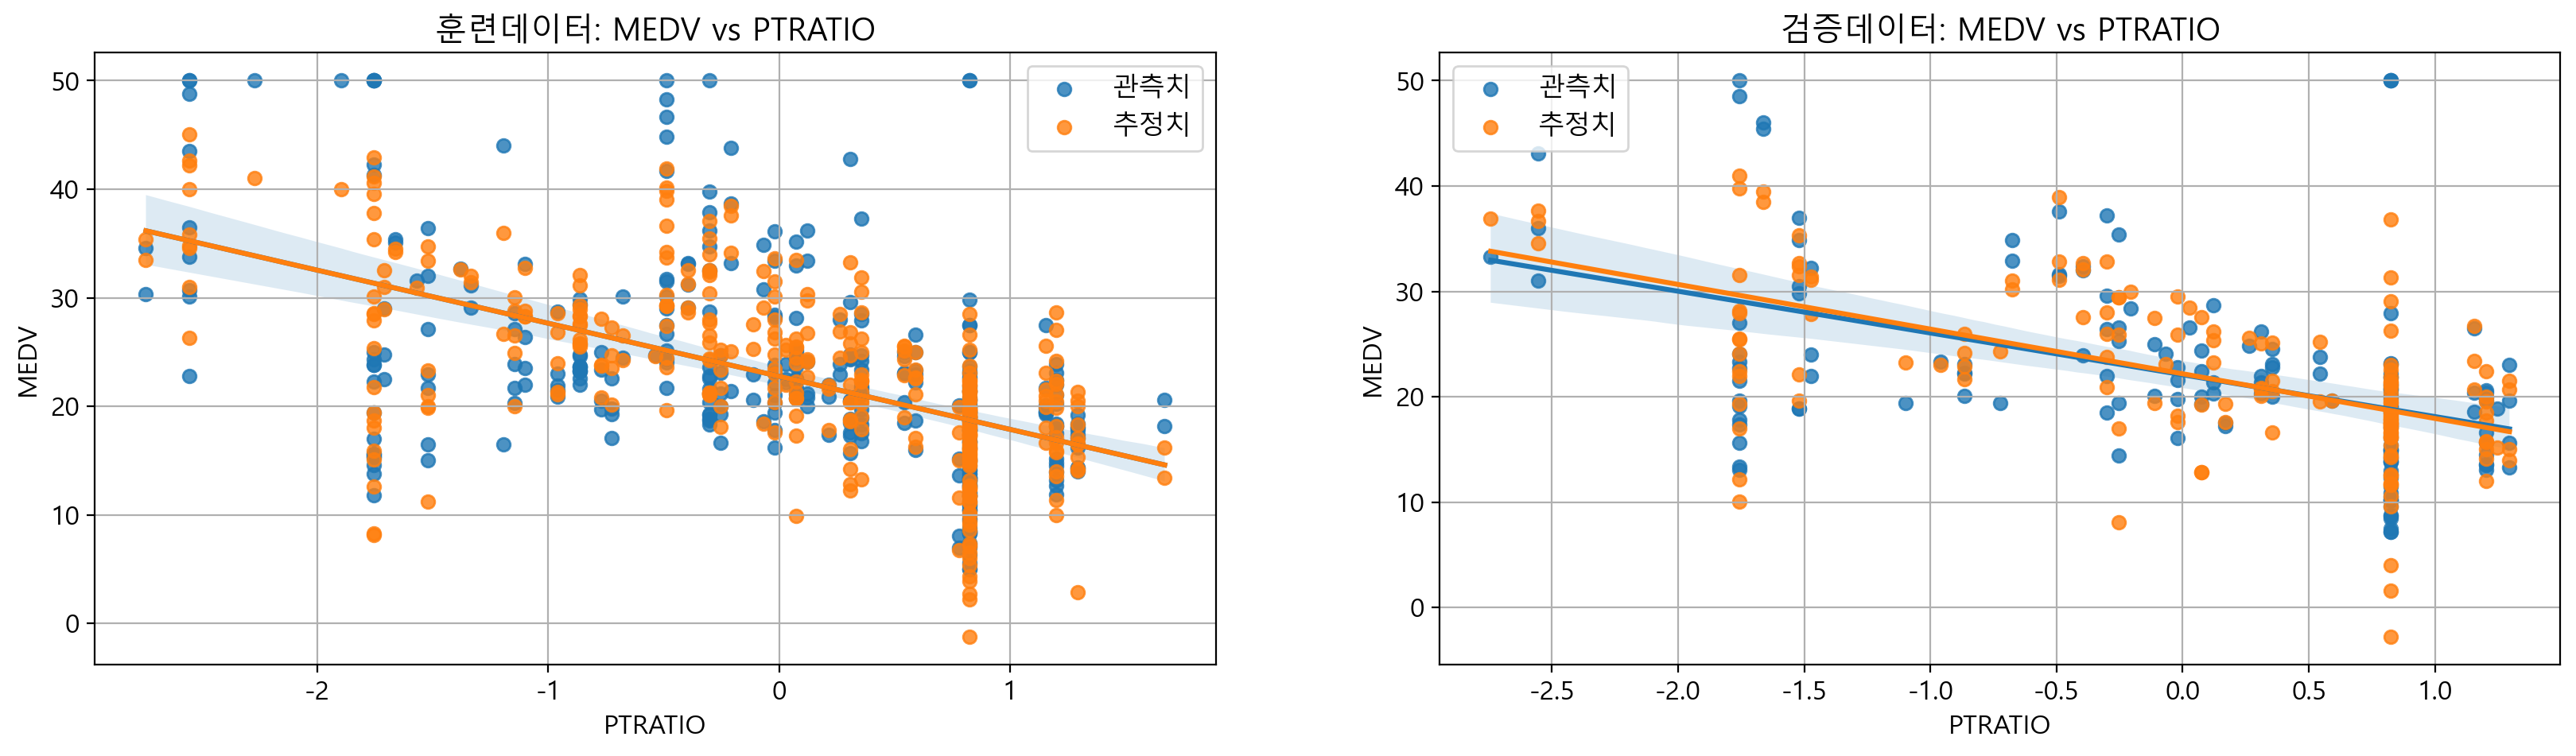

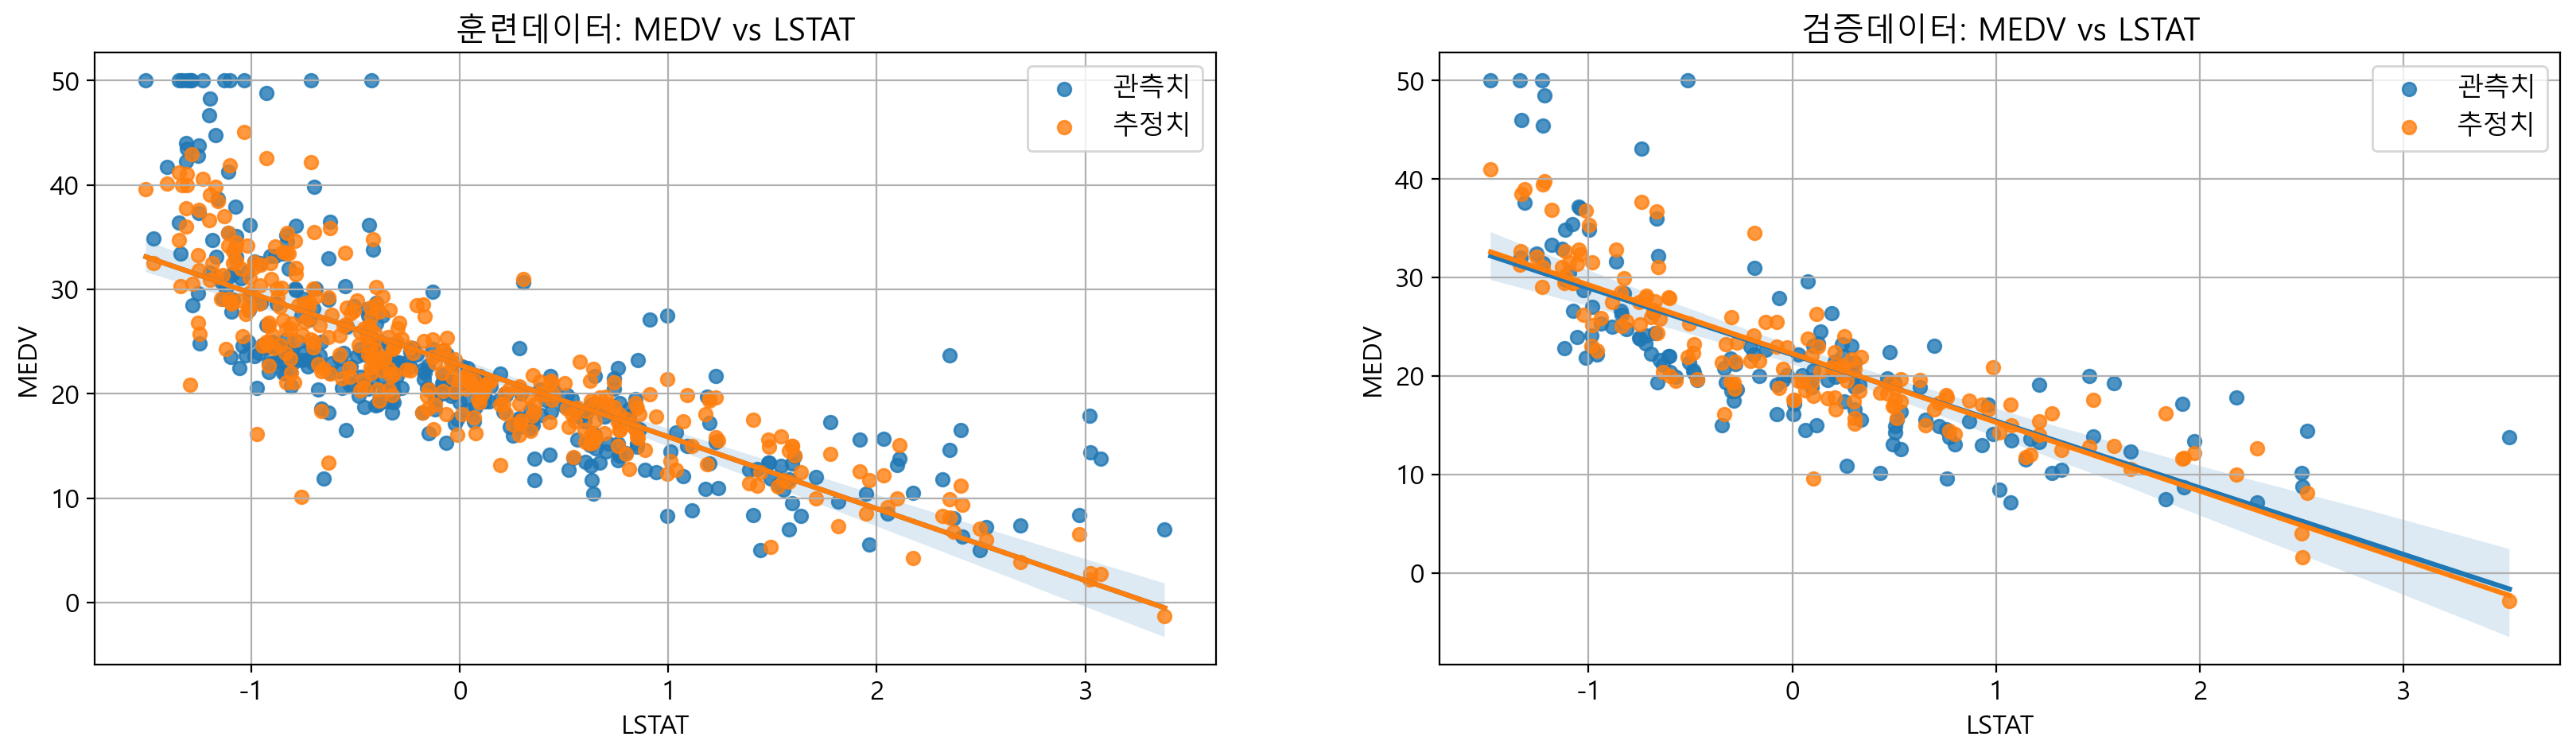

In [5]:
fit = my_linear_regression(x_train, y_train, x_test, y_test, use_plot=True, report=True)

## #03. 잔차 분석

일반적으로 검증데이터에 대해 수행한다.

### [1] 잔차 구하기

In [6]:
# 예측치
y_pred = fit.predict(x_test)

# 잔차
resid = y_test - y_pred

resid_df = DataFrame({"resid": resid}).reset_index(drop=True)
resid_df

,resid
0,-6.389163
1,-1.895478
2,5.933878
3,2.961458
4,4.704038
...,...
147,-1.480395
148,-5.978637
149,0.245207
150,-8.088950


### [2] 선형성

#### (1) 정규분포 확인

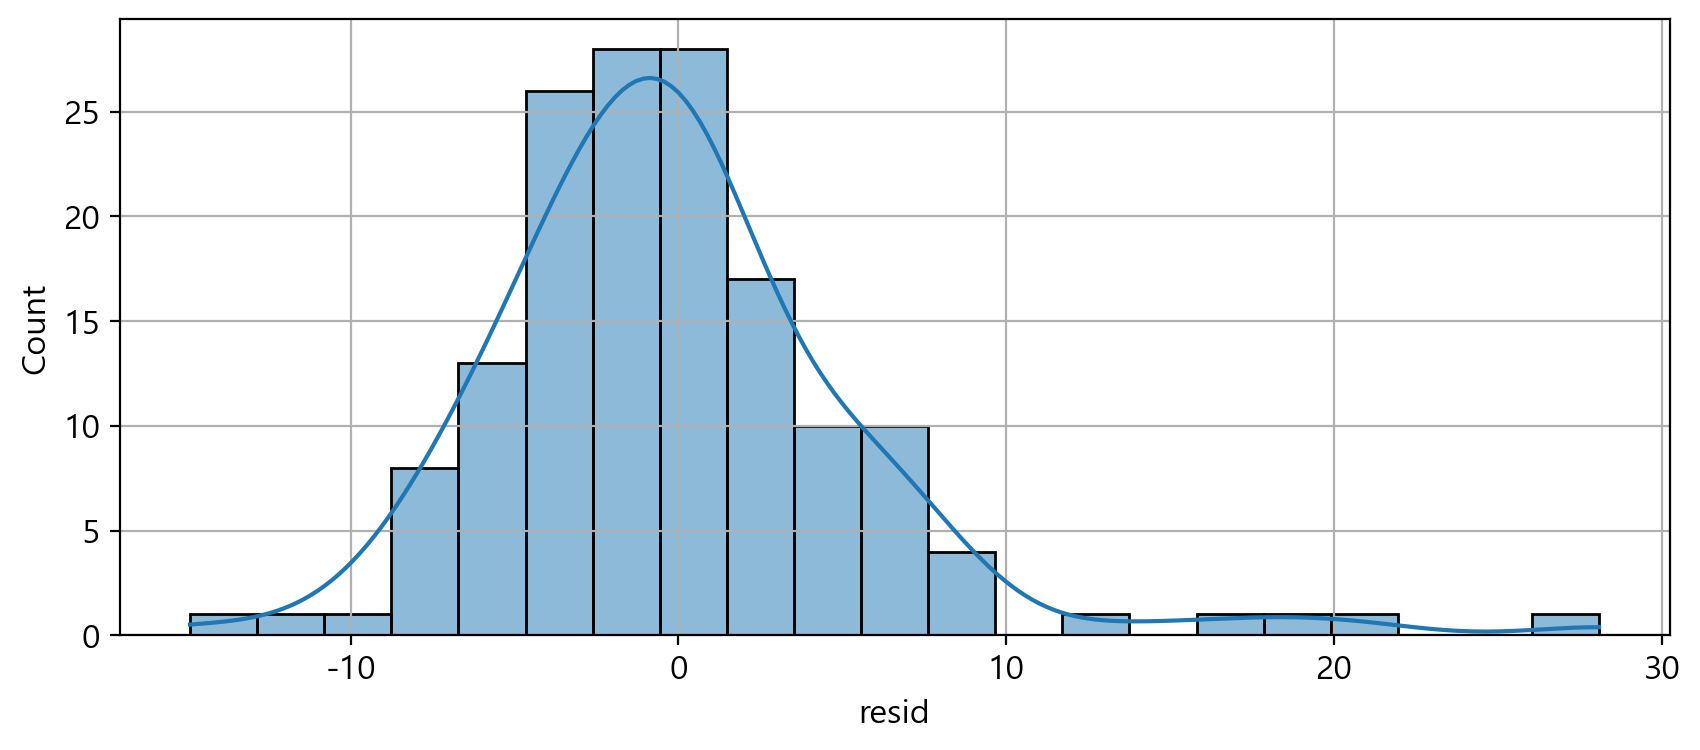

In [7]:
my_histplot(resid_df, xname='resid')

#### (2) 잔차 그래프

- 모든 예측값에 대한 잔차가 가운데 점선에 맞추어 비슷하게 있어야 한다.
- 빨간 실선은 잔차의 추세를 의미
- 빨간 실선이 점선에서 크게 벗어난다면 잔차가 크게 달라진다는 의미이므로 선형성이 없다는 것이다.

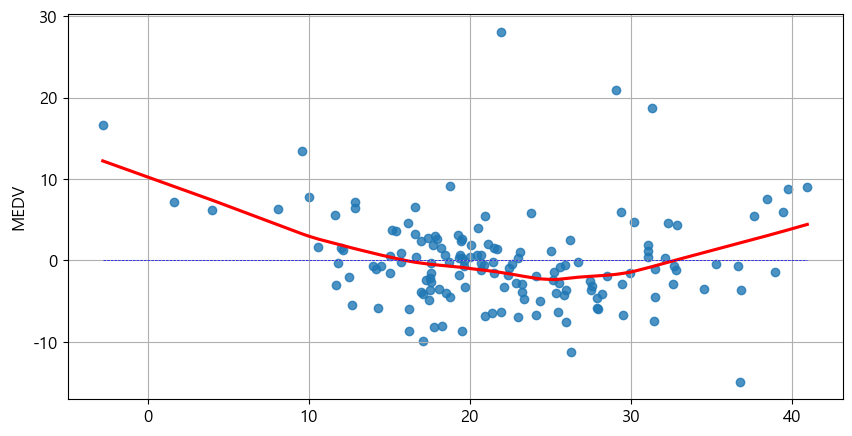

In [9]:
plt.figure(figsize=(10, 5))

sns.regplot(x=y_pred, y=resid, lowess=True, line_kws={'color': 'red'})
sns.lineplot(x=[y_pred.min(), y_pred.max()], y=[0, 0], color='blue', linestyle='--', linewidth=0.5)
plt.grid()
plt.show()
plt.close()

### [3] 정규성

#### (1) QQPlot

- 잔차가 정규분포를 따르면 Q-Q Plot에서 점들이 점선을 따라 배치된다.
- 구해 놓은 예측값을 활용하여 zscore 값을 구한다.

##### probplot 함수를 사용한 자동 생성

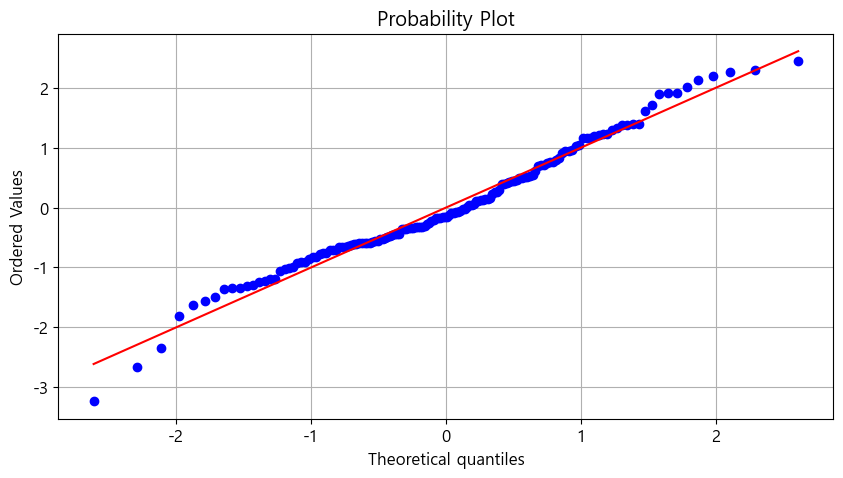

In [10]:
zs = zscore(y_pred)

plt.figure(figsize=(10, 5))
probplot(zs, plot=plt)
plt.grid()
plt.show()
plt.close()

##### x,y 좌표를 반환받은 후 직접 시각화

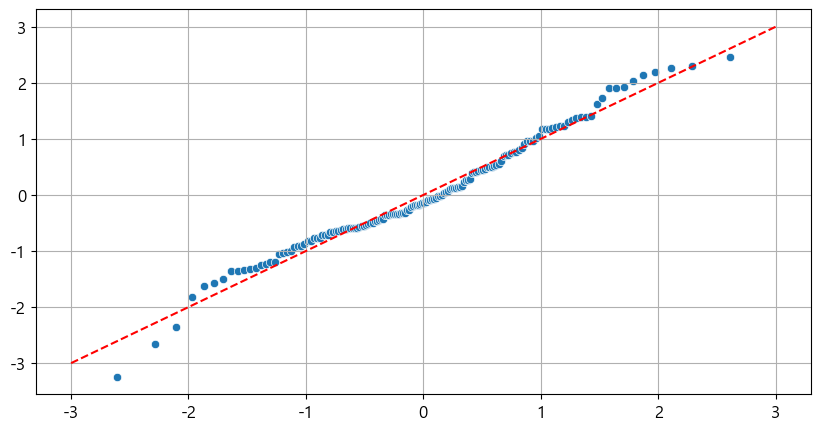

In [17]:
zs = zscore(y_pred)

plt.figure(figsize=(10, 5))
(x, y), _ = probplot(zs)

sns.scatterplot(x=x, y=y)
sns.lineplot(x=[-3, 3], y=[-3, 3], color='red', linestyle='--')

plt.grid()
plt.show()
plt.close()

#### (2) 잔차도

잔차가 정규분포를 따른다면 대략적으로...

- $\pm\sqrt{MSE}$ 범위 안에 최소 `68%`의 잔차가 포함된다.
- $\pm2\sqrt{MSE}$ 범위 안에 최소 `95%`의 잔차가 포함된다.
- $\pm3\sqrt{MSE}$ 범위 안에 최소 `99%`의 잔차가 포함된다.

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse_sq = np.sqrt(mse)

r1 = resid[ (resid > -mse_sq) & (resid < mse_sq)].count() / resid.count() * 100
r2 = resid[ (resid > -2*mse_sq) & (resid < 2*mse_sq)].count() / resid.count() * 100
r3 = resid[ (resid > -3*mse_sq) & (resid < 3*mse_sq)].count() / resid.count() * 100

mse_r = [r1, r2, r3]

print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:1.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:1.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:1.2f}%")

루트 1MSE 구간에 포함된 잔차 비율: 74.34%
루트 2MSE 구간에 포함된 잔차 비율: 96.05%
루트 3MSE 구간에 포함된 잔차 비율: 98.03%


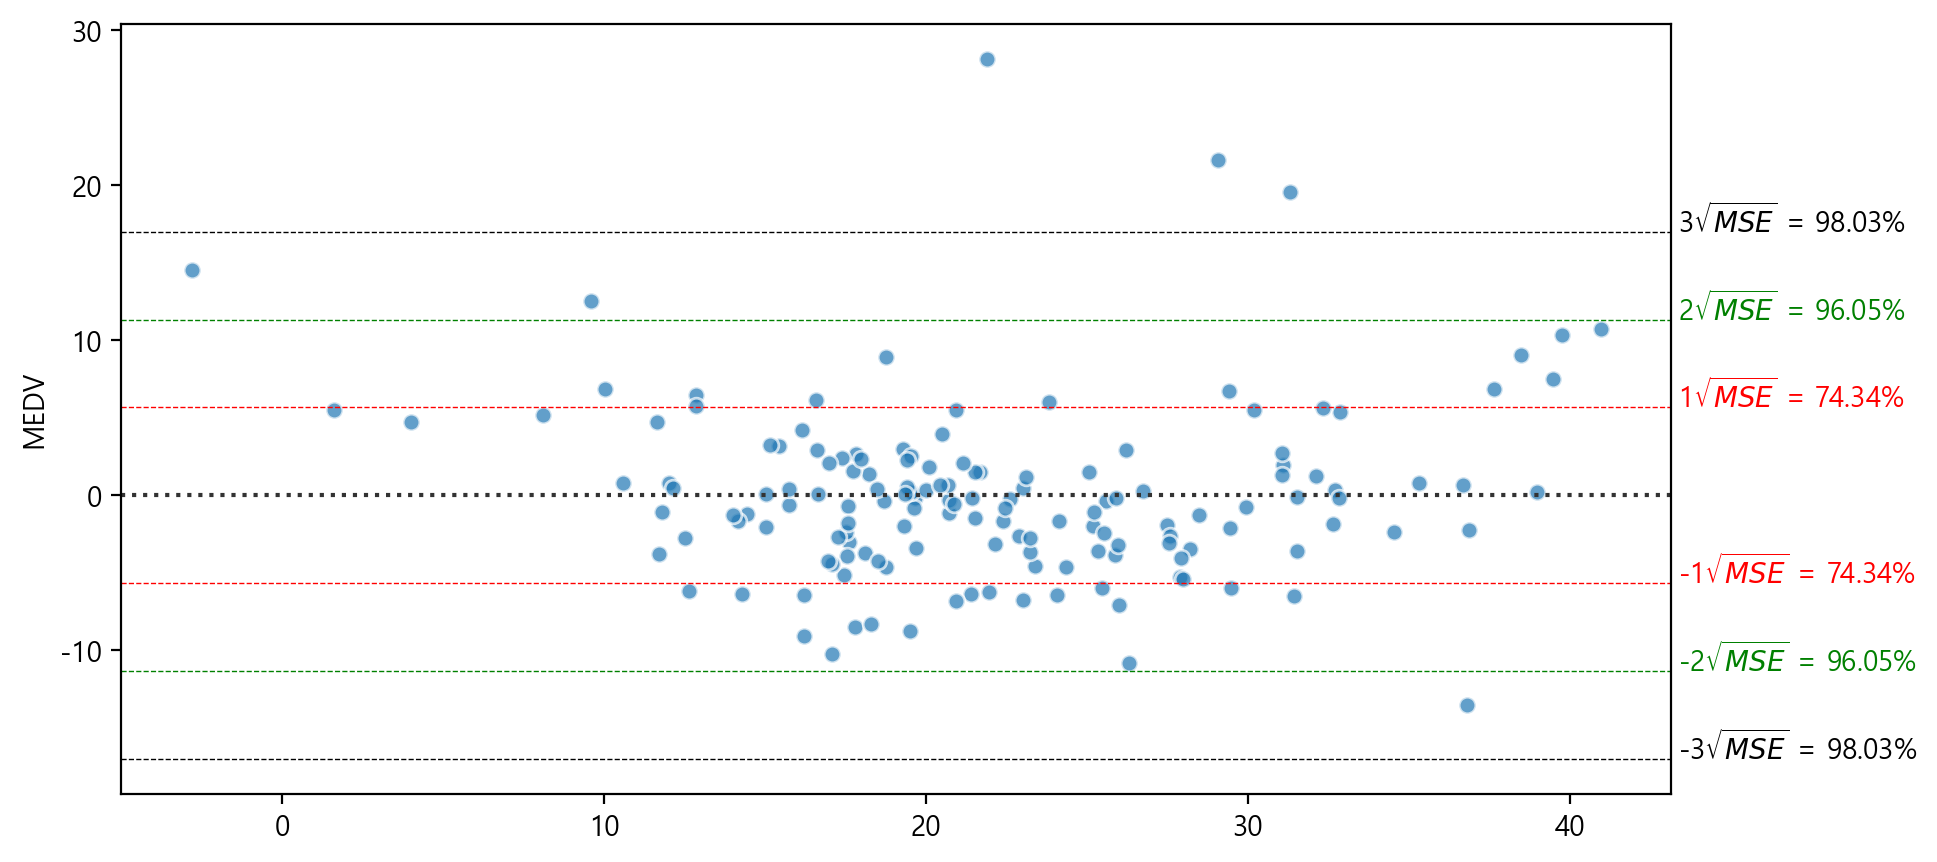

In [ ]:
plt.figure(figsize=(10, 5))

# 일반적인 잔차도
# sb.residplot(x=y_pred, y=resid, lowess=True, line_kws={'color': 'red'})

sb.residplot(x=y_pred, y=resid, 
             scatter_kws = {'edgecolor':"white", "alpha":0.7})

for i, c in enumerate(['red', 'green', 'black']):
    plt.axhline(mse_sq * (i+1), color=c, linestyle='--', linewidth=0.5)
    plt.axhline(mse_sq * (-(i+1)), color=c, linestyle='--', linewidth=0.5)

# 현재 표시되는 그래프의 x축 범위를 가져온다.
xmin, xmax = plt.xlim()

for i, c in enumerate(['red', 'green', 'black']):
    plt.text(s=f"{i+1}"r'${}\sqrt{MSE}$ = %.2f%%' % mse_r[i], x=xmax+0.2, y=(i+1)*mse_sq, color=c)
    plt.text(s=f"-{i+1}"r'${}\sqrt{MSE}$ = %.2f%%' % mse_r[i], x=xmax+0.2, y=-(i+1)*mse_sq, color=c)

plt.show()
plt.close()

### [4] 등분산성

### [5] 독립성

회귀분석 결과표 하단의 Dubin-Watson 값을 확인한다.

| 수치 | 해석 |
|---|---|
| `0` | 잔차들이 양의 상관 관계 (독립성 X) |
| `2` | 잔차들이 독립 |
| `4` | 잔차들이 음의 상관 관계 (독립성 X) |

일반적으로 DW값이 `1.5` ~ `2.5` 범위에 있으면 독립으로 판정

In [ ]:
dw = durbin_watson(resid)
print(f"Durbin-Watson: {dw}, 독립성 가정 만족 여부: {dw > 1.5 and dw < 2.5}")

Durbin-Watson: 1.9279407375238424, 독립성 가정 만족 여부: True
